In [1]:
pip install pesq

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torchmetrics

  Using cached torchmetrics-1.2.1-py3-none-any.whl (806 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install torchaudio

  Using cached torchaudio-2.1.2-cp38-cp38-manylinux1_x86_64.whl (3.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install pystoi

  Using cached pystoi-0.4.0-py2.py3-none-any.whl (8.1 kB)
Note: you may need to restart the kernel to use updated packages.


Mean Squared Error (MSE): 0.6627382040023804
PESQ Score (NB): 2.2076363563537598
PESQ Score (WB): 1.7359119653701782
STOI Score:  tensor(-0.0102)


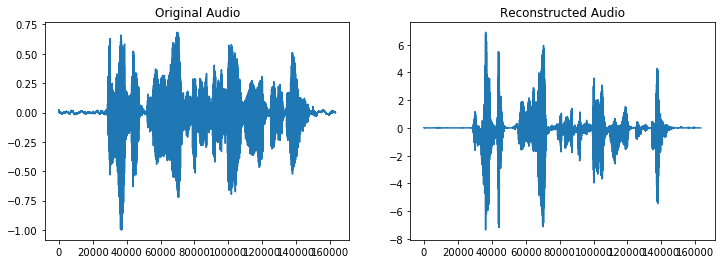

In [4]:
import torchaudio
import torch
import torchmetrics
import matplotlib.pyplot as plt
from torch import randn
from torchmetrics.functional.audio.pesq import perceptual_evaluation_speech_quality
from torchaudio.utils import download_asset
from pystoi.stoi import stoi
from torchmetrics.audio import ShortTimeObjectiveIntelligibility

class AudioProcessor:
    def __init__(self):
        pass 

    def load_and_resample_audio(self, file_path, target_sample_rate):
        """
        Load an audio file, resample it to the target sample rate, and return the resampled waveform.

        Args:
            file_path (str): Path to the audio file.
            target_sample_rate (int): Target sample rate for resampling.

        Returns:
            torch.Tensor: Resampled audio waveform.
            int: Target sample rate.
        """
        waveform, original_sample_rate = torchaudio.load(file_path)
        resampler = torchaudio.transforms.Resample(original_sample_rate, target_sample_rate)
        resampled_waveform = resampler(waveform)
        return resampled_waveform, target_sample_rate

    def compute_stft(self, audio_waveform, sample_rate, n_fft=400, hop_length=160, win_length=400):
        """
        Compute the Short-Time Fourier Transform (STFT) of an audio waveform.

        Args:
            audio_waveform (torch.Tensor): Input audio waveform.
            sample_rate (int): Sample rate of the input audio.
            n_fft (int): Size of the FFT.
            hop_length (int): Number of samples between successive frames.
            win_length (int): Size of the window function.

        Returns:
            torch.Tensor: Magnitude of the STFT.
            torch.Tensor: Phase of the STFT.
        """
        stft_transform = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length, win_length=win_length)
        spectrogram = stft_transform(audio_waveform)
        magnitude = torch.abs(spectrogram)
        phase = torch.angle(spectrogram)
        return magnitude, phase

    def compute_istft(self, magnitude, phase, sample_rate, n_fft=400, hop_length=160, win_length=400):
        """
        Compute the Inverse Short-Time Fourier Transform (ISTFT) to reconstruct audio waveform.

        Args:
            magnitude (torch.Tensor): Magnitude of the STFT.
            phase (torch.Tensor): Phase of the STFT.
            sample_rate (int): Sample rate of the audio waveform.
            n_fft (int): Size of the FFT.
            hop_length (int): Number of samples between successive frames.
            win_length (int): Size of the window function.

        Returns:
            torch.Tensor: Reconstructed audio waveform.
        """
        spectrogram_complex = magnitude * torch.exp(1j * phase)
        reconstructed_waveform = torch.istft(
            spectrogram_complex, 
            n_fft=n_fft, 
            hop_length=hop_length, 
            win_length=win_length, 
            window=torch.hann_window(win_length),
            center=True
        )
        return reconstructed_waveform

    def compare_audio(self, original_waveform, result_waveform):
        """
        Compare original and reconstructed audio waveforms using Mean Squared Error (MSE).

        Args:
            original_waveform (torch.Tensor): Original audio waveform.
            result_waveform (torch.Tensor): Reconstructed audio waveform.
        """
        assert original_waveform.shape == result_waveform.shape, "Shapes of original and result waveforms must be the same."
        mse_loss = torch.nn.MSELoss()
        mse = mse_loss(original_waveform, result_waveform)
        print(f"Mean Squared Error (MSE): {mse.item()}")

    def evaluate_audio(self, original_waveform, result_waveform, sample_rate):
        """
        Evaluate audio quality using PESQ and STOI metrics.

        Args:
            original_waveform (torch.Tensor): Original audio waveform.
            result_waveform (torch.Tensor): Reconstructed audio waveform.
            sample_rate (int): Sample rate of the audio waveforms.
        """
        g = torch.manual_seed(1)
        preds = randn(8000)
        target = randn(8000)
        pesq_nb = perceptual_evaluation_speech_quality(preds, target, 8000, 'nb')
        pesq_wb = perceptual_evaluation_speech_quality(preds, target, 16000, 'wb')
        print(f"PESQ Score (NB): {pesq_nb.item()}")
        print(f"PESQ Score (WB): {pesq_wb.item()}")
        stoi = ShortTimeObjectiveIntelligibility(8000, False)
        print(f"STOI Score: ", stoi(preds, target))

if __name__ == "__main__":
    # Instantiate the AudioProcessor class
    audio_processor = AudioProcessor()

    # Sample WAV file path
    SAMPLE_WAV = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

    # Load and resample audio
    resampled_waveform, target_sample_rate = audio_processor.load_and_resample_audio(SAMPLE_WAV, 48000)

    # Compute STFT
    magnitude, phase = audio_processor.compute_stft(resampled_waveform, target_sample_rate)

    # Compute ISTFT
    reconstructed_waveform = audio_processor.compute_istft(magnitude, phase, target_sample_rate)

    # Compare original and result audio
    audio_processor.compare_audio(resampled_waveform, reconstructed_waveform)

    # Evaluate PESQ and STOI
    audio_processor.evaluate_audio(resampled_waveform, reconstructed_waveform, target_sample_rate)

    # Plot original and result waveforms
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(resampled_waveform[0].numpy())
    plt.title("Original Audio")

    plt.subplot(1, 2, 2)
    plt.plot(reconstructed_waveform[0].numpy())
    plt.title("Reconstructed Audio")

    plt.show()
